In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
# import geopandas as gpd

In [2]:
df_sst = xr.open_dataset("data/sst.mon.mean.nc")
df_sst

<xarray.Dataset> Size: 545MB
Dimensions:  (lat: 180, lon: 360, time: 2103)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 17kB 1850-01-01 1850-02-01 ... 2025-03-01
Data variables:
    sst      (time, lat, lon) float32 545MB ...
Attributes:
    title:            created 12/2013 from data provided by JRA
    history:          Created 12/2012 from data obtained from JRA by ESRL/PSD
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pub/ocean/cobe-sst2/
    References:       http://www.psl.noaa.gov/data/gridded/cobe2.html

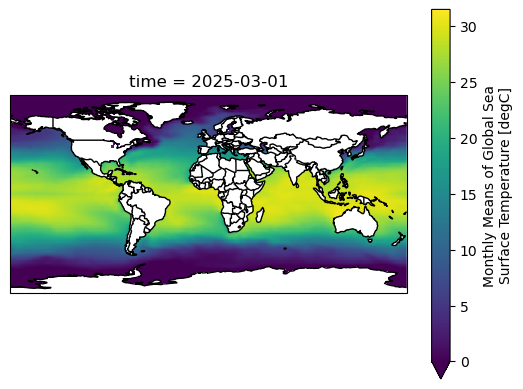

In [3]:
sst = df_sst.sst.sel(time = "2025-03-01")
ax = plt.axes(projection=ccrs.PlateCarree()) # Note that I changed the projection
sst.plot(ax=ax, transform=ccrs.PlateCarree(), vmin = 0)
ax.add_feature(cartopy.feature.BORDERS); # What do you think this command does? 
ax.coastlines();

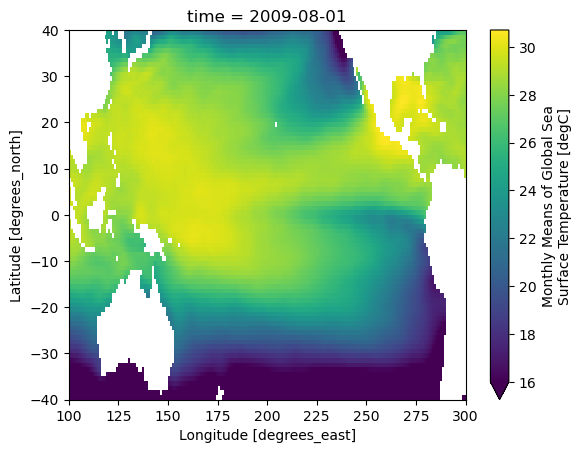

In [4]:
eq_pac = df_sst.sst.sel(lon = slice(100,300), lat = slice(40, -40))
eq_pac.sel(time = "2009-08-01").plot(vmin = 16)

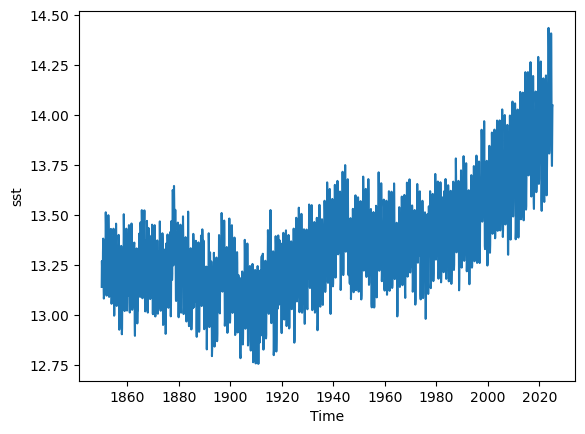

In [5]:
df_sst.sst.mean(dim = ["lat", "lon"]).plot()

In [6]:
df_anom = xr.open_dataset("data/sst.mon.anom.nc")
df_anom

<xarray.Dataset> Size: 21MB
Dimensions:  (lat: 36, lon: 72, time: 2005)
Coordinates:
  * lat      (lat) float32 144B -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 288B 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
  * time     (time) datetime64[ns] 16kB 1856-01-01 1856-02-01 ... 2023-01-01
Data variables:
    sst      (time, lat, lon) float32 21MB ...
Attributes:
    title:          Kaplan Extended SST V2
    platform:       Analysis
    Conventions:    COARDS
    history:        Originally converted from the IRI format to netCDF3 10/20...
    dataset_title:  Kaplan Extended V2 SST anomaly data
    description:    Data is processed at Lamont-Doherty using an \noptimal an...
    References:     https://www.psl.noaa.gov/data/gridded/data.kaplan_sst.html

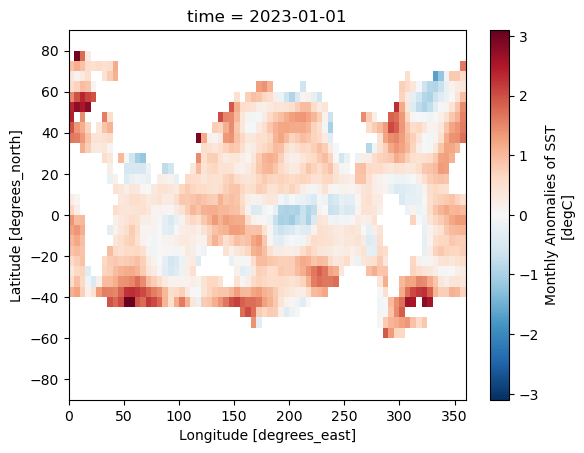

In [7]:
df_anom.sst.sel(time = "2023-01-01").plot()

This dataset is not very helpful--not great resolution. Might still be useful in terms of prediction.

In [8]:
df = pd.read_csv('./data/detrend.nino34.ascii.txt', sep='\s+')

In [9]:
df

,YR,MON,TOTAL,ClimAdjust,ANOM
0,1950,1,24.56,26.18,-1.62
1,1950,2,25.07,26.39,-1.32
2,1950,3,25.88,26.95,-1.07
3,1950,4,26.29,27.39,-1.11
4,1950,5,26.19,27.56,-1.37
...,...,...,...,...,...
898,2024,11,26.46,26.70,-0.25
899,2024,12,26.00,26.60,-0.60
900,2025,1,25.82,26.55,-0.73
901,2025,2,26.34,26.76,-0.43


An anomaly of < -0.5 indicates La Nina and > 0.5 indicates El Nino. In between those values is considered neutral.

<Axes: >

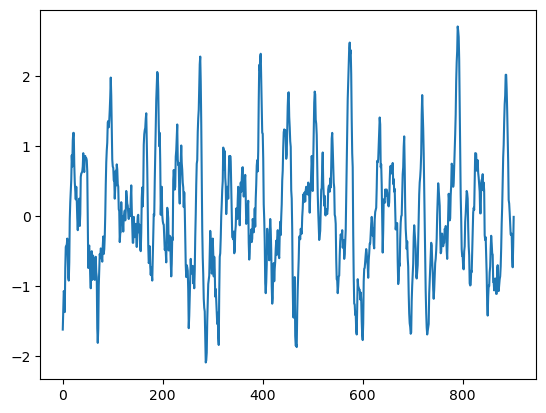

In [10]:
df.ANOM.plot()

In [11]:
yearly_anoms = df[df["YR"] != 2025].groupby('YR').mean()
yearly_anoms

,MON,TOTAL,ClimAdjust,ANOM
YR,,,,
1950,6.5,25.731667,26.590833,-0.858333
1951,6.5,27.027500,26.590833,0.437500
1952,6.5,26.745000,26.590833,0.155833
1953,6.5,27.320833,26.590833,0.727500
1954,6.5,26.178333,26.590833,-0.410833
...,...,...,...,...
2020,6.5,26.720000,27.082500,-0.361667
2021,6.5,26.360000,27.082500,-0.721667
2022,6.5,26.146667,27.082500,-0.939167


In [12]:
enso_labels_multinomial = pd.Series(np.zeros_like(yearly_anoms.ANOM))
enso_labels_multinomial

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
70    0.0
71    0.0
72    0.0
73    0.0
74    0.0
Length: 75, dtype: float64

In [13]:
enso_labels_multinomial.loc[yearly_anoms["ANOM"].to_numpy() < -0.5] = 1
enso_labels_multinomial.loc[yearly_anoms["ANOM"].to_numpy() > 0.5] = 2
enso_labels_multinomial


0     1.0
1     0.0
2     0.0
3     2.0
4     0.0
     ... 
70    0.0
71    1.0
72    1.0
73    2.0
74    0.0
Length: 75, dtype: float64

In [14]:
enso_labels = pd.Series(np.zeros_like(df.ANOM))
enso_labels.loc[df.ANOM > 0] = 1

Now we have a table of ENSO stages. 0 is neutral, 1 is La Nina, and 2 is El Nino. Simplified ENSO labels are 1 for El Nino, 0 for La Nina.

<Axes: >

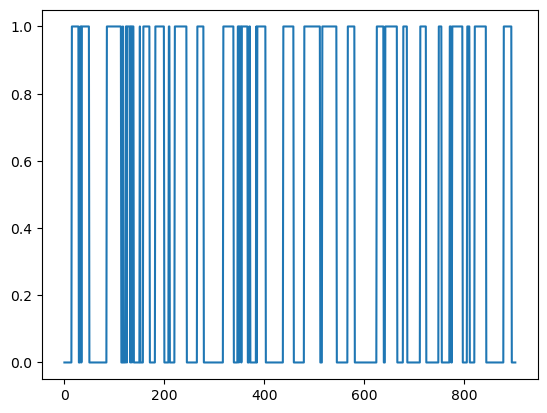

In [15]:
enso_labels.plot()

<Axes: xlabel='YR'>

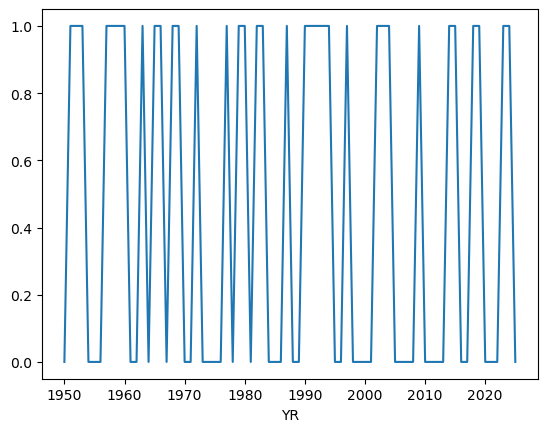

In [16]:
df["Phase"] = enso_labels
df.groupby('YR')['Phase'].mean().round().plot()


Will probably keep monthly data but this is cool to see.

Going to keep wrestling with the data with different time scales.

In [17]:
filtered_sst = eq_pac.sel(time=df_sst.time.dt.year >= 1950)
filtered_sst

<xarray.DataArray 'sst' (time: 903, lat: 80, lon: 200)> Size: 58MB
[14448000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 320B 39.5 38.5 37.5 36.5 ... -36.5 -37.5 -38.5 -39.5
  * lon      (lon) float32 800B 100.5 101.5 102.5 103.5 ... 297.5 298.5 299.5
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2025-03-01
Attributes:
    long_name:     Monthly Means of Global Sea Surface Temperature
    valid_range:   [-5. 40.]
    units:         degC
    var_desc:      Sea Surface Temperature
    dataset:       COBE-SST2 Sea Surface Temperature
    statistic:     Mean
    parent_stat:   Individual obs
    level_desc:    Surface
    actual_range:  [-3.0000002 34.392    ]

IDEA: split into regions of equatorial pacific, take means/max/min of those areas, then those regions are features. Probably won't work too well but we can try. Or each lat/lon pair is a feature but that would be a crazy amount of features.

In [18]:
# trying to make every lat lon pair a feature
# This is commented out because it took way too long to run, and I had to keyboard-interrupt it.

# df = pd.DataFrame()
# for i in filtered_sst.lat:
#     for j in filtered_sst.lon:
#         loc = filtered_sst.sel(lat = i, lon = j).values
#         name = f"{i}, {j}"
#         df[name] = loc

In [19]:
lat_strips = [40, 20, 0, -20, -40]
lon_strips = [100, 120, 140, 160, 180, 200, 220, 240, 260, 280]

In [20]:
# making regions in the pacific
df2 = pd.DataFrame()
for i in range(len(lat_strips) - 1):
    for j in range(len(lon_strips) - 1):
        loc = filtered_sst.sel(lat = slice(lat_strips[i], lat_strips[i+1]), lon = slice(lon_strips[i], lon_strips[i+1])).mean(dim = ["lat", "lon"])
        name = f"Region {i}, {j}"
        df2[name] = loc

In [21]:
df2 = df2.dropna()

In [22]:
df2["year"] = df["YR"]
df2["anom"] = df["ANOM"]
df2

,"Region 0, 0","Region 0, 1","Region 0, 2","Region 0, 3","Region 0, 4","Region 0, 5","Region 0, 6","Region 0, 7","Region 0, 8","Region 1, 0",...,"Region 3, 1","Region 3, 2","Region 3, 3","Region 3, 4","Region 3, 5","Region 3, 6","Region 3, 7","Region 3, 8",year,anom
0,19.286787,19.286787,19.286787,19.286787,19.286787,19.286787,19.286787,19.286787,19.286787,27.525190,...,22.952324,22.952324,22.952324,22.952324,22.952324,22.952324,22.952324,22.952324,1950,-1.62
1,18.773643,18.773643,18.773643,18.773643,18.773643,18.773643,18.773643,18.773643,18.773643,27.323544,...,23.434601,23.434601,23.434601,23.434601,23.434601,23.434601,23.434601,23.434601,1950,-1.32
2,19.756405,19.756405,19.756405,19.756405,19.756405,19.756405,19.756405,19.756405,19.756405,27.672237,...,23.157417,23.157417,23.157417,23.157417,23.157417,23.157417,23.157417,23.157417,1950,-1.07
3,21.712620,21.712620,21.712620,21.712620,21.712620,21.712620,21.712620,21.712620,21.712620,28.290886,...,22.478662,22.478662,22.478662,22.478662,22.478662,22.478662,22.478662,22.478662,1950,-1.11
4,24.781118,24.781118,24.781118,24.781118,24.781118,24.781118,24.781118,24.781118,24.781118,28.991953,...,21.402229,21.402229,21.402229,21.402229,21.402229,21.402229,21.402229,21.402229,1950,-1.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,24.176962,24.176962,24.176962,24.176962,24.176962,24.176962,24.176962,24.176962,24.176962,29.304232,...,21.136753,21.136753,21.136753,21.136753,21.136753,21.136753,21.136753,21.136753,2024,-0.25
899,21.053329,21.053329,21.053329,21.053329,21.053329,21.053329,21.053329,21.053329,21.053329,28.882446,...,23.022379,23.022379,23.022379,23.022379,23.022379,23.022379,23.022379,23.022379,2024,-0.60
900,18.548906,18.548906,18.548906,18.548906,18.548906,18.548906,18.548906,18.548906,18.548906,28.522257,...,23.469835,23.469835,23.469835,23.469835,23.469835,23.469835,23.469835,23.469835,2025,-0.73
901,17.895237,17.895237,17.895237,17.895237,17.895237,17.895237,17.895237,17.895237,17.895237,28.177679,...,24.172411,24.172411,24.172411,24.172411,24.172411,24.172411,24.172411,24.172411,2025,-0.43


In [23]:
# removing the year 2025 because it only had 3 months--messed up the yearly average.
df2 = df2[df2["year"] != 2025]

In [24]:
df2 = df2.groupby("year").mean()
df2

,"Region 0, 0","Region 0, 1","Region 0, 2","Region 0, 3","Region 0, 4","Region 0, 5","Region 0, 6","Region 0, 7","Region 0, 8","Region 1, 0",...,"Region 3, 0","Region 3, 1","Region 3, 2","Region 3, 3","Region 3, 4","Region 3, 5","Region 3, 6","Region 3, 7","Region 3, 8",anom
year,,,,,,,,,,,,,,,,,,,,,
1950,23.551161,23.551161,23.551161,23.551161,23.551161,23.551161,23.551161,23.551161,23.551161,28.365919,...,21.104273,21.104273,21.104273,21.104273,21.104273,21.104273,21.104273,21.104273,21.104273,-0.858333
1951,23.496088,23.496088,23.496088,23.496088,23.496088,23.496088,23.496088,23.496088,23.496088,28.406092,...,20.736349,20.736349,20.736349,20.736349,20.736349,20.736349,20.736349,20.736349,20.736349,0.437500
1952,23.856524,23.856524,23.856524,23.856524,23.856524,23.856524,23.856524,23.856524,23.856524,28.550211,...,20.854952,20.854952,20.854952,20.854952,20.854952,20.854952,20.854952,20.854952,20.854952,0.155833
1953,23.653936,23.653936,23.653936,23.653936,23.653936,23.653936,23.653936,23.653936,23.653936,28.474669,...,20.793112,20.793112,20.793112,20.793112,20.793112,20.793112,20.793112,20.793112,20.793112,0.727500
1954,23.530626,23.530626,23.530626,23.530626,23.530626,23.530626,23.530626,23.530626,23.530626,28.526083,...,20.904730,20.904730,20.904730,20.904730,20.904730,20.904730,20.904730,20.904730,20.904730,-0.410833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,24.217653,24.217653,24.217653,24.217653,24.217653,24.217653,24.217653,24.217653,24.217653,29.310127,...,21.521566,21.521566,21.521566,21.521566,21.521566,21.521566,21.521566,21.521566,21.521566,-0.361667
2021,24.441378,24.441378,24.441378,24.441378,24.441378,24.441378,24.441378,24.441378,24.441378,29.268469,...,21.433250,21.433250,21.433250,21.433250,21.433250,21.433250,21.433250,21.433250,21.433250,-0.721667
2022,24.348722,24.348722,24.348722,24.348722,24.348722,24.348722,24.348722,24.348722,24.348722,29.221886,...,21.839737,21.839737,21.839737,21.839737,21.839737,21.839737,21.839737,21.839737,21.839737,-0.939167


<Axes: xlabel='year', ylabel='Region 0, 0'>

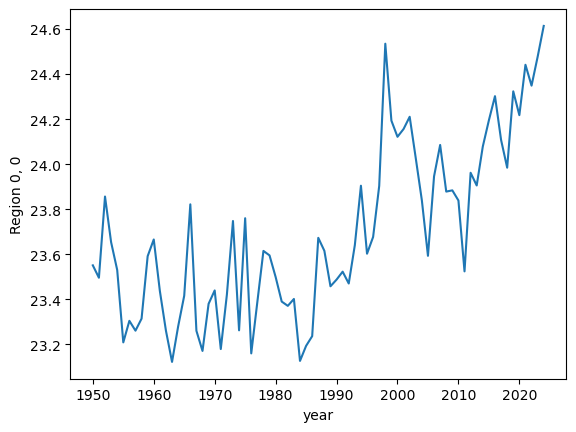

In [25]:
sns.lineplot(df2, x="year", y="Region 0, 0")

We can see a clear temperature increase since the 70s, but hopefully our model can recognize the trend of dips and peaks.

<Axes: xlabel='year', ylabel='anom'>

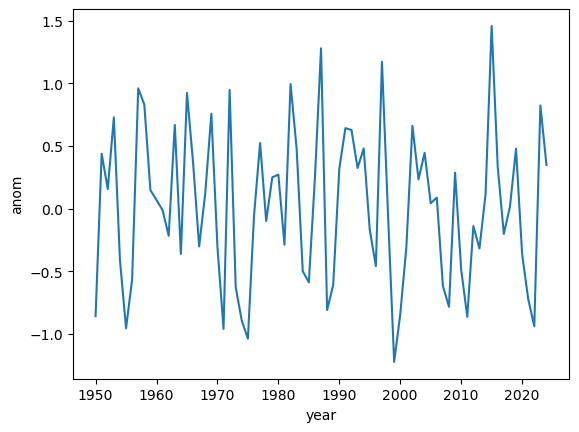

In [26]:
sns.lineplot(df2, x = "year", y = "anom")

In [27]:
df2["label"] = 0
df2["label"] = df2["label"].where(df2["anom"] < 0, other=1)

In [28]:
anoms = df2["anom"].to_numpy()
yearly_labels = pd.Series(np.zeros_like(anoms))
yearly_labels.loc[anoms > 0] = 1
yearly_labels

0     0.0
1     1.0
2     1.0
3     1.0
4     0.0
     ... 
70    0.0
71    0.0
72    0.0
73    1.0
74    1.0
Length: 75, dtype: float64

y is enso_labels, X is df. Let's get these babies into tensor format.

In [29]:
X = torch.from_numpy(df2.drop("anom", axis=1).drop("label", axis=1).to_numpy())
y = torch.tensor(df2["label"].to_numpy())
X = X.double()

All right, let's just see if it works...

In [30]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer, AdamOptimizer

Now we will try Gradient Descent and Adam optimizers.

In [ ]:
GD = GradientDescentOptimizer()
GD_loss = []
for t in range(1000):
    loss = GD.loss(X, y)
    GD_loss.append(loss)
    GD.step(X, y, 0.001, 0.8)

In [ ]:
newton = NewtonOptimizer()
newton_loss = []


In [44]:
adam = AdamOptimizer()
adam_loss = []
t = 1
loss = torch.inf
while loss>=59 or torch.isnan(loss):
    loss = adam.loss(X, y)
    adam_loss.append(loss)
    adam.step(X, y, 10, 0.001, 0.0, 0.0, t)
    t+=1

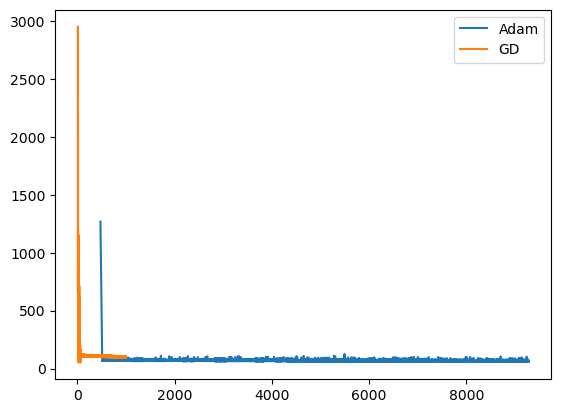

In [45]:
fig, ax = plt.subplots()
ax.plot(adam_loss, label="Adam")
ax.plot(GD_loss, label="GD")
ax.legend()

In [46]:
adam.predict(X)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])

In [47]:
GD.predict(X)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])

In [41]:
adam_predicted = adam.predict(X)
(adam_predicted == y).sum()/len(adam_predicted)

tensor(0.5200)

In [42]:
gd_predicted = GD.predict(X)
(gd_predicted == y).sum()/len(gd_predicted)

tensor(0.5200)

In [ ]:
X = df2.drop("anom", axis=1)

In [ ]:
df2.drop("anom", axis=1)

,"Region 0, 0","Region 0, 1","Region 0, 2","Region 0, 3","Region 0, 4","Region 0, 5","Region 0, 6","Region 0, 7","Region 0, 8","Region 1, 0",...,"Region 3, 0","Region 3, 1","Region 3, 2","Region 3, 3","Region 3, 4","Region 3, 5","Region 3, 6","Region 3, 7","Region 3, 8",label
year,,,,,,,,,,,,,,,,,,,,,
1950,23.551161,23.551161,23.551161,23.551161,23.551161,23.551161,23.551161,23.551161,23.551161,28.365919,...,21.104273,21.104273,21.104273,21.104273,21.104273,21.104273,21.104273,21.104273,21.104273,0
1951,23.496088,23.496088,23.496088,23.496088,23.496088,23.496088,23.496088,23.496088,23.496088,28.406092,...,20.736349,20.736349,20.736349,20.736349,20.736349,20.736349,20.736349,20.736349,20.736349,1
1952,23.856524,23.856524,23.856524,23.856524,23.856524,23.856524,23.856524,23.856524,23.856524,28.550211,...,20.854952,20.854952,20.854952,20.854952,20.854952,20.854952,20.854952,20.854952,20.854952,1
1953,23.653936,23.653936,23.653936,23.653936,23.653936,23.653936,23.653936,23.653936,23.653936,28.474669,...,20.793112,20.793112,20.793112,20.793112,20.793112,20.793112,20.793112,20.793112,20.793112,1
1954,23.530626,23.530626,23.530626,23.530626,23.530626,23.530626,23.530626,23.530626,23.530626,28.526083,...,20.904730,20.904730,20.904730,20.904730,20.904730,20.904730,20.904730,20.904730,20.904730,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,24.217653,24.217653,24.217653,24.217653,24.217653,24.217653,24.217653,24.217653,24.217653,29.310127,...,21.521566,21.521566,21.521566,21.521566,21.521566,21.521566,21.521566,21.521566,21.521566,0
2021,24.441378,24.441378,24.441378,24.441378,24.441378,24.441378,24.441378,24.441378,24.441378,29.268469,...,21.433250,21.433250,21.433250,21.433250,21.433250,21.433250,21.433250,21.433250,21.433250,0
2022,24.348722,24.348722,24.348722,24.348722,24.348722,24.348722,24.348722,24.348722,24.348722,29.221886,...,21.839737,21.839737,21.839737,21.839737,21.839737,21.839737,21.839737,21.839737,21.839737,0


In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df2.drop("anom", axis=1), test_size = 0.4) # 0.4 is the best ratio for test data it seems...otherwise not enough test or not enough train data
X_train = df_train.drop("label", axis = 1)
y_train = df_train["label"]
X_test = df_test.drop("label", axis = 1)
y_test = df_test["label"]

In [ ]:
# try with sklearn implementation
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(solver = "liblinear")
# liblinear and lbfgs are the best solvers here. Implement parts of these into my linear regression implementation!
LR.fit(X_train, y_train)
liblinear = LR.score(X_test, y_test)


In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(solver = "lbfgs")
# liblinear and lbfgs are the best solvers here. Implement parts of these into my linear regression implementation!
LR.fit(X_train, y_train)
lbfgs = liblinear = LR.score(X_test, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(X_train, y_train)
rf = RF.score(X_test, y_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
print(nb.predict(X_test))
bayes = nb.score(X_test, y_test)

[1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1]


In [ ]:
#trying plain gradient descent just to check that mine isn't broken.

from sklearn.linear_model import SGDClassifier

SGD = SGDClassifier(loss="log_loss")
SGD.fit(X_train, y_train)
print(SGD.predict(X_test))
sgd = SGD.score(X_test, y_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
df = pd.DataFrame(columns = ["score"], index = ["Naive Bayes", "Random Forest", "LR: liblinear", "LR: SGD", "LR: LBFGS"])
df["score"] = [bayes, rf, liblinear, sgd, lbfgs]

In [ ]:
df

,score
Naive Bayes,0.500000
Random Forest,0.533333
LR: liblinear,0.700000
LR: SGD,0.466667
LR: LBFGS,0.700000


Text(0.5, 1.0, 'Score of each sklearn classification model')

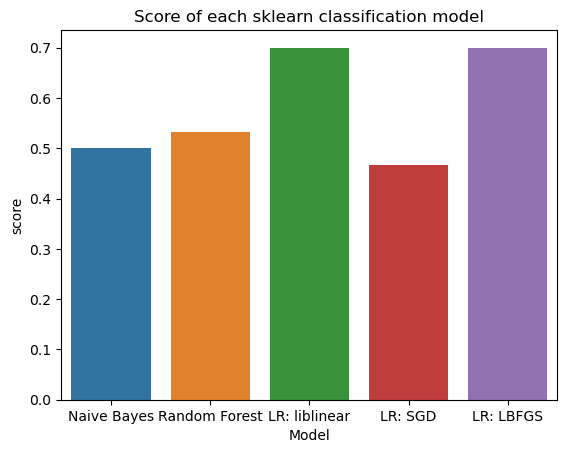

In [ ]:
ax = sns.barplot(df, x = df.index, y = "score", hue = df.index)
ax.set_xlabel("Model")
ax.set_title("Score of each sklearn classification model")

It seems that Logistic Regression and Naive Bayes are working best here. Depending on the train-test split, either Bayes or LR performs better, so I would categorize them as both the best methods. Sometimes Random Forest will overtake them, but this seems like it is based on chance and not based on actual superiority of the model.

The sklearn Gradient Descent implementation is also struggling to classify this data (always all 1s or all 0s). In the future, I'd try to implement LBFGS or liblinear optimizers (the solvers that worked the best for Logistic Regression) in order to better classify the data.